## 泰坦尼克号乘客生存预测-数据挖掘流程实战

In [523]:
# 导入所需要的工具包
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [524]:
# 导入数据
data=pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [525]:
# 看看有木有缺失值
data.isnull().sum() # checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [526]:
# 整体看看数据啥规模
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


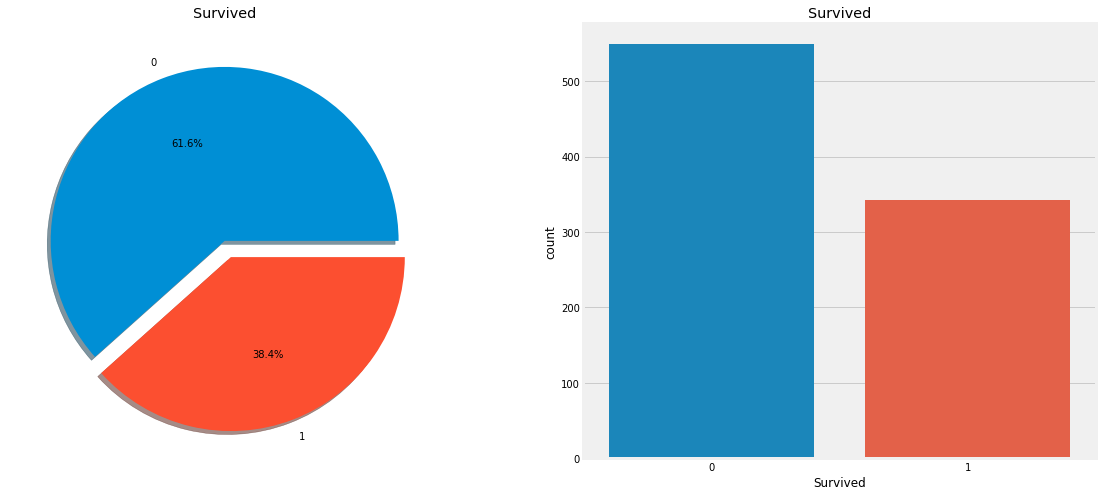

In [527]:
# 不是要预测这大船的获救情况嘛，先看看获救比例咋样
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

显然，这次事故中没有多少乘客幸免于难。

在训练集的891名乘客中，只有大约350人幸存下来，只有38.4%的机组人员在空难中幸存下来。我们需要从数据中挖掘出更多的信息，看看哪些类别的乘客幸存下来，哪些没有。

我们将尝试使用数据集的不同特性来检查生存率。比如性别，年龄，登船地点等，但是首先我们得来理解下数据中的特征！


## 数据特征分为：连续值和离散值
* 离散值：性别（男，女） 登船地点（S,Q,C）

* 连续值：年龄，船票价格

In [528]:
# 按照性别对生存情况进行分组
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

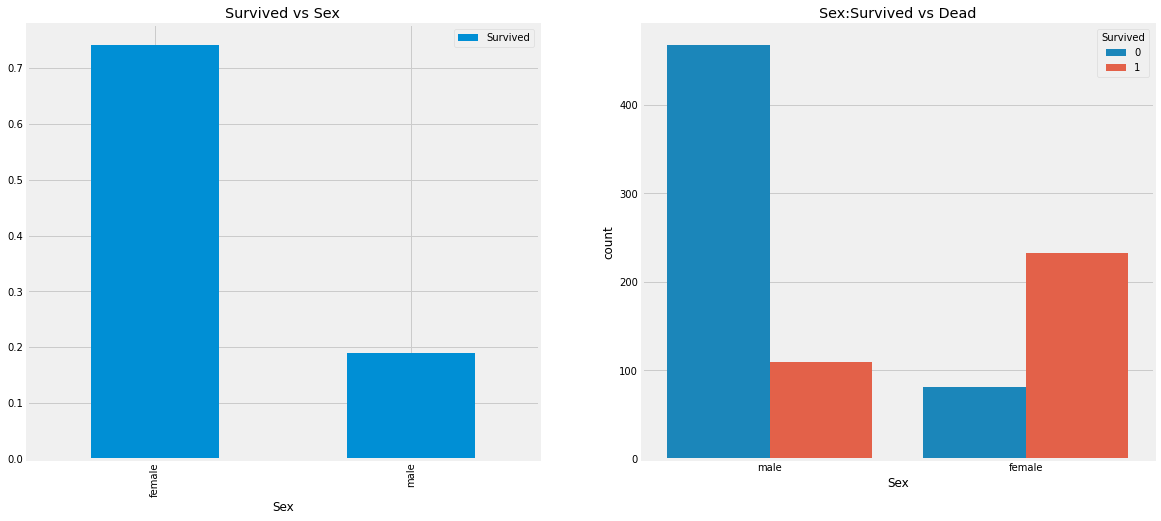

In [529]:
# 绘图可视化出生存与性别的关系
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

这看起来很有趣。船上的男人比女人多得多。不过，挽救的女性人数几乎是男性的两倍。生存率为一个女人在船上是75%左右，而男性在18-19%左右。（让妇女和儿童先走，虽然电影忘得差不多了，这句话还记着。。。确实是这样的）

这看起来是建模的一个非常重要的特性。一会我们会用上他的！

In [530]:
# 年龄特征与生存的关系
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


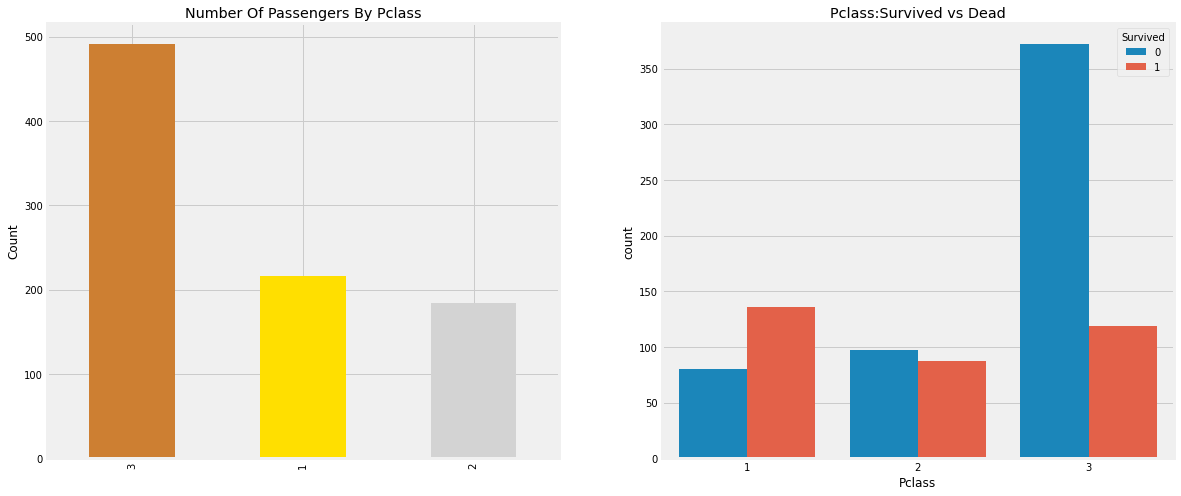

In [531]:
# 绘图可视化出生存与船舱等级的关系
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

人们说金钱不能买到一切。但我们可以清楚地看到，船舱等级为1的被给予很高的优先级而救援。尽管数量在pClass 3乘客高了很多，仍然存活数从他们是非常低的，大约25%。

对于pClass1来说存活是63%左右，而pclass2大约是48%。所以金钱和地位很重要。这样一个物欲横流的世界。

那这些又和性别有关吗？接下来我们再来看看船舱等级和性别对结果的影响

In [532]:
# 船舱等级和性别对结果的影响(交叉表)
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

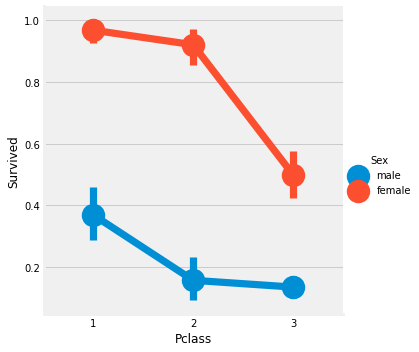

In [533]:
# 绘图可视化
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

我们用factorplot这个图，看起来更直观一些。

我们可以很容易地推断，从pclass1女性生存是95-96%，如94人中只有3的女性从pclass1没获救。

显而易见的是，不论pClass，女性优先考虑。

看来Pclass也是一个重要的特征。让我们分析其他特征

In [534]:
# Age--> 连续值特征对结果的影响
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')


Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


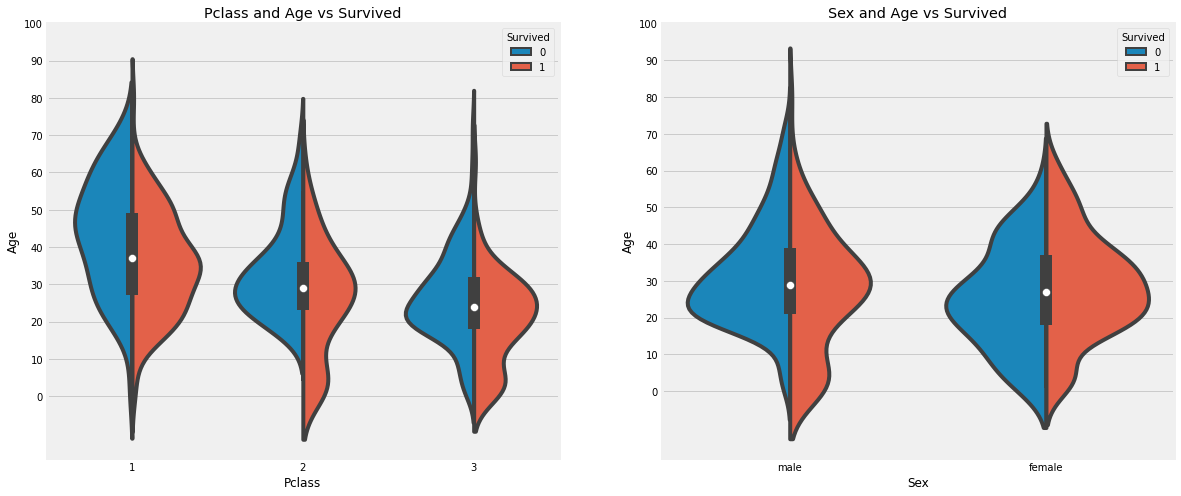

In [535]:
# 绘图可视化出年龄与船舱等级、性别对生存的影响和关系
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

结果：¶
1）10岁以下儿童的存活率随passenegers数量增加。

2）生存为20-50岁获救几率更高一些。

3）对男性来说，随着年龄的增长，存活率降低。

## 缺失值填充
* 平均值
* 经验值 
* 回归模型预测
* 剔除掉

正如我们前面看到的，年龄特征有177个空值。为了替换这些缺失值，我们可以给它们分配数据集的平均年龄。

但问题是，有许多不同年龄的人。最好的办法是找到一个合适的年龄段！

我们可以检查名字特征。根据这个特征，我们可以看到名字有像先生或夫人这样的称呼，这样我们就可以把先生和夫人的平均值分配给各自的组。


In [536]:
# 好了，这里我们使用正则表达式：[A-Za-z] +）来提取信息
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') 

In [537]:
# 画出相应的交叉表
pd.crosstab(data.Initial,data.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [538]:
# 进行替换
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [539]:
# 按照分组来求平均年龄
data.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [540]:
## 使用每组的均值来进行填充缺失值
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [541]:
data.Age.isnull().any() #看看填充完了咋样

False

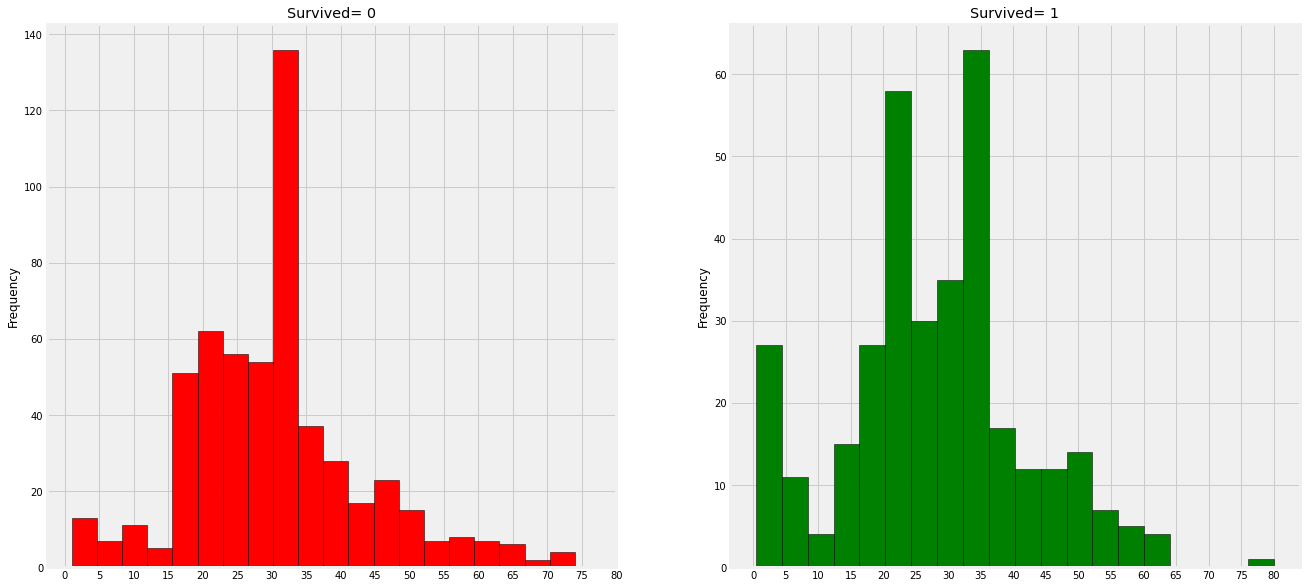

In [542]:
# 绘图可视化
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()


观察:

1）幼儿（年龄在5岁以下）获救的还是蛮多的（妇女和儿童优先政策）。

2）最老的乘客得救了（80年）。

3）死亡人数最高的是30-40岁年龄组。

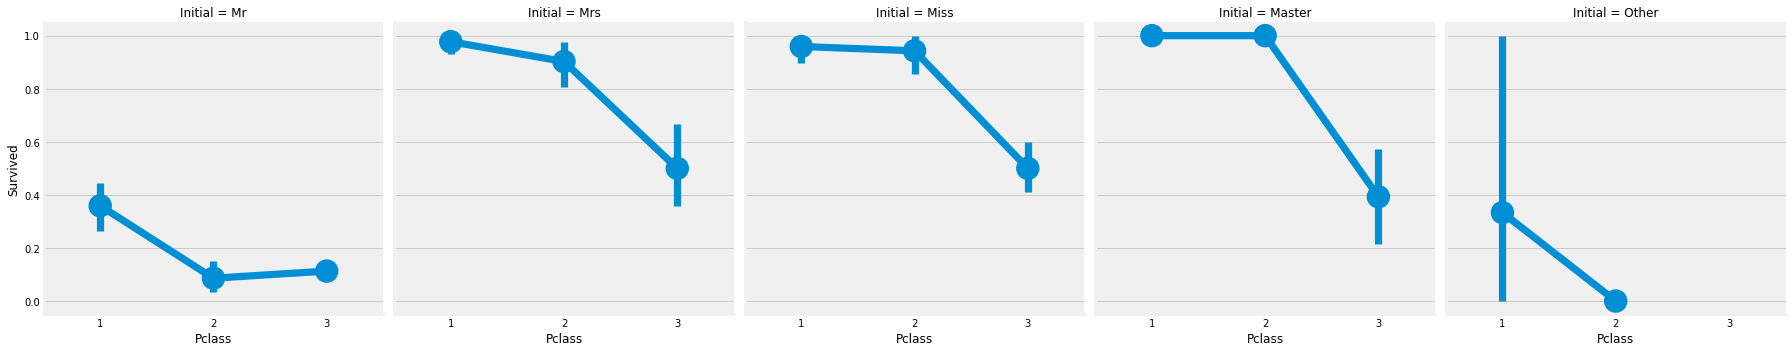

In [543]:
sns.factorplot('Pclass','Survived',col='Initial',data=data)
plt.show()

因此，无论性别如何，妇女和儿童第一政策都是正确的。

In [544]:
# Embarked--> 登船地点特征分析
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True).style.background_gradient(cmap='summer_r')

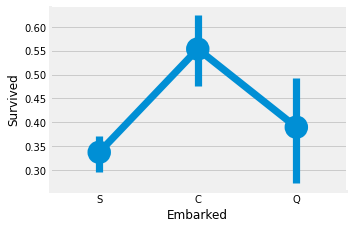

In [545]:
sns.factorplot('Embarked','Survived',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

C港生存的可能性最高在0.55左右，而S的生存率最低。

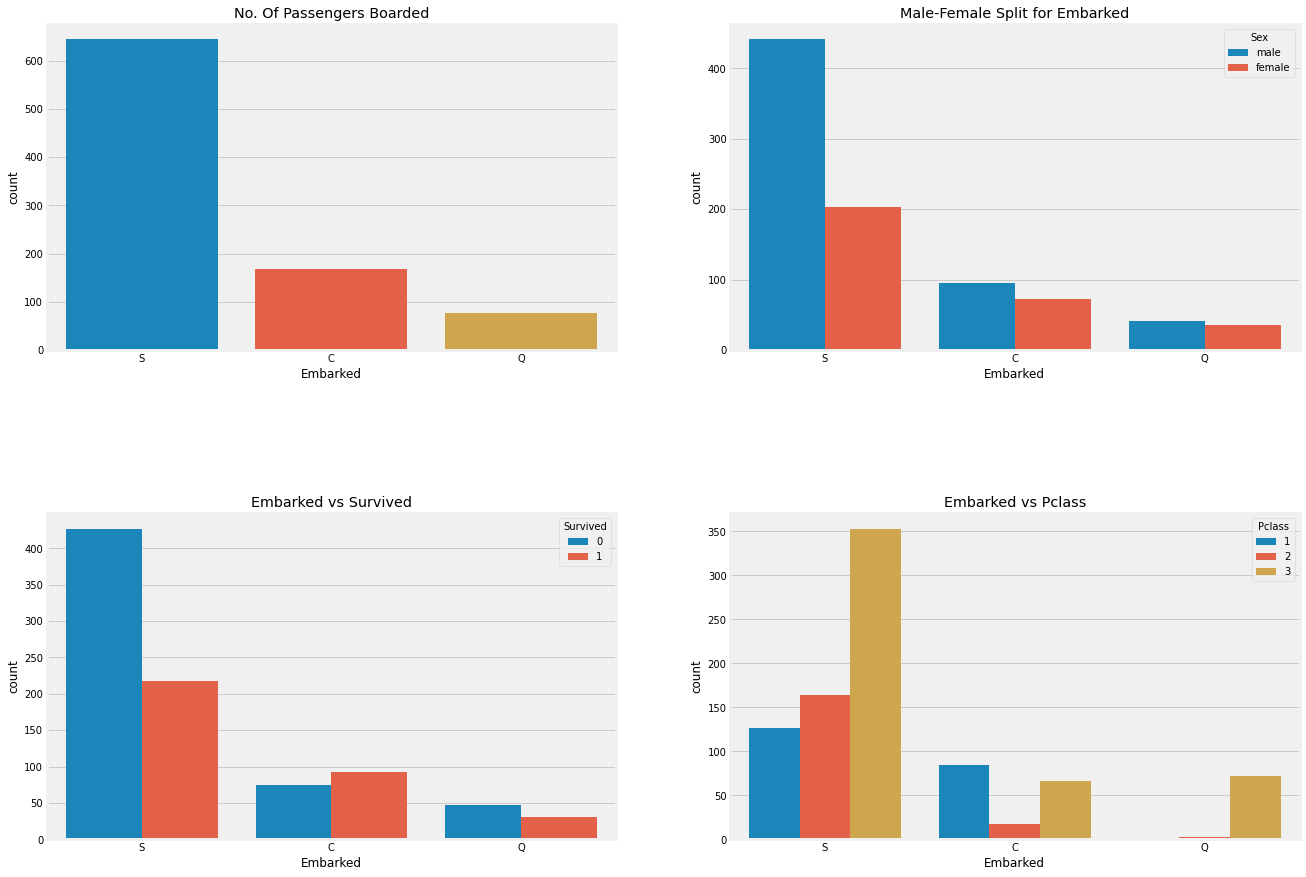

In [546]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

观察:

1）大部分人的船舱等级是3。

2）C的乘客看起来很幸运，他们中的一部分幸存下来。

3）S港口的富人蛮多的。仍然生存的机会很低。

4）港口Q几乎有95%的乘客都是穷人。


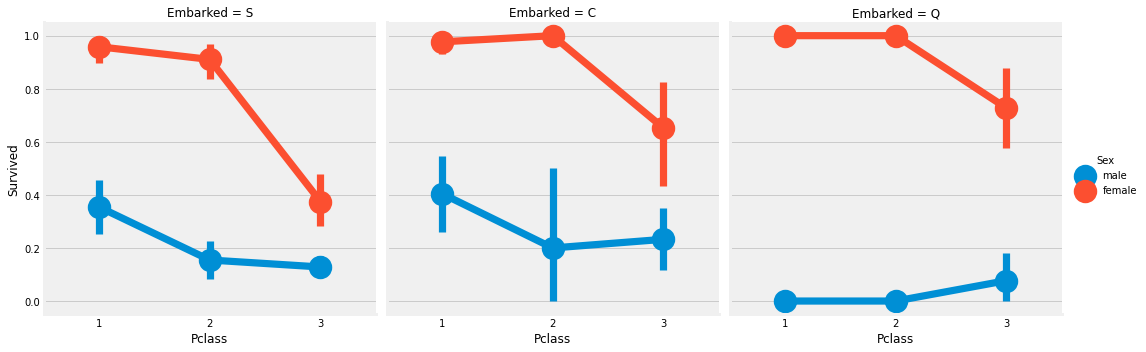

In [547]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

观察:

1）存活的几率几乎为1 在pclass1和pclass2中的女人。

2）pclass3 的乘客中男性和女性的生存率都是很偏低的。

3）端口Q很不幸，因为那里都是3等舱的乘客。


港口中也存在缺失值，在这里我用众数来进行填充了，因为S登船人最多呀

In [548]:
# 对港口的缺失值进行填充
data['Embarked'].fillna('S',inplace=True)

In [549]:
data.Embarked.isnull().any()

False

In [550]:
# sibsip -->兄弟姐妹的数量
# 这个特征表示一个人是独自一人还是与他的家人在一起
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


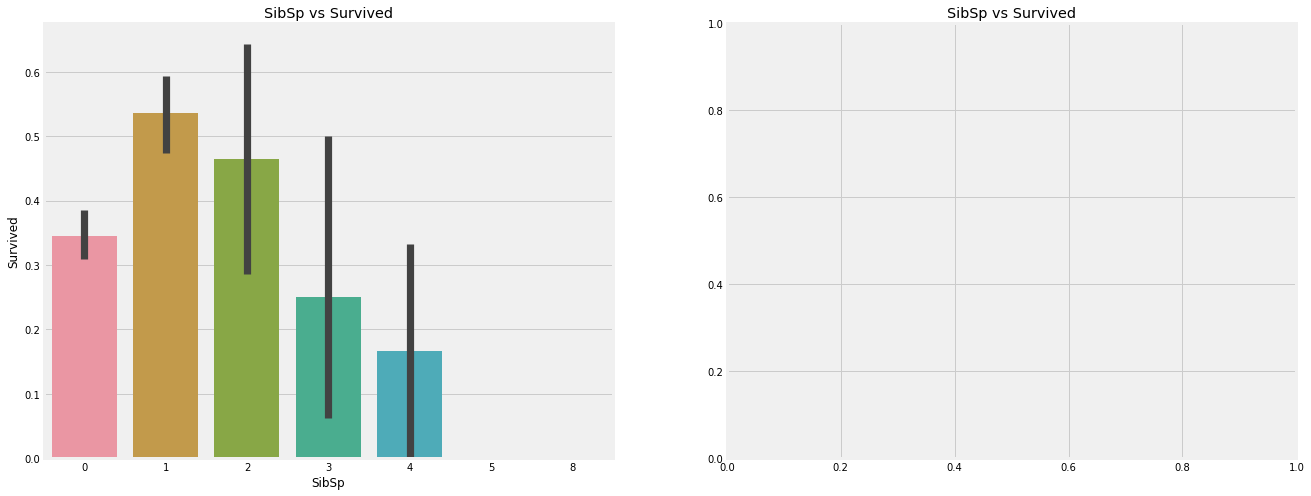

In [551]:
# 绘图显示是否有兄弟姐妹与存活的关系
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [552]:
# 画出是否有兄弟姐妹与船舱等级的交叉表
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


观察:

barplot和factorplot表明，如果乘客是孤独的船上没有兄弟姐妹，他有34.5%的存活率。如果兄弟姐妹的数量增加，概率大致减少。这是有道理的。也就是说，如果我有一个家庭在船上，我会尽力拯救他们，而不是先救自己。但是令人惊讶的是，5-8名成员家庭的存活率为0%。原因可能是他们在pclass=3的船舱？


In [553]:
# Parch --> 父母和孩子的数量
pd.crosstab(data.Parch,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


再次表明，大家庭都在pclass3。

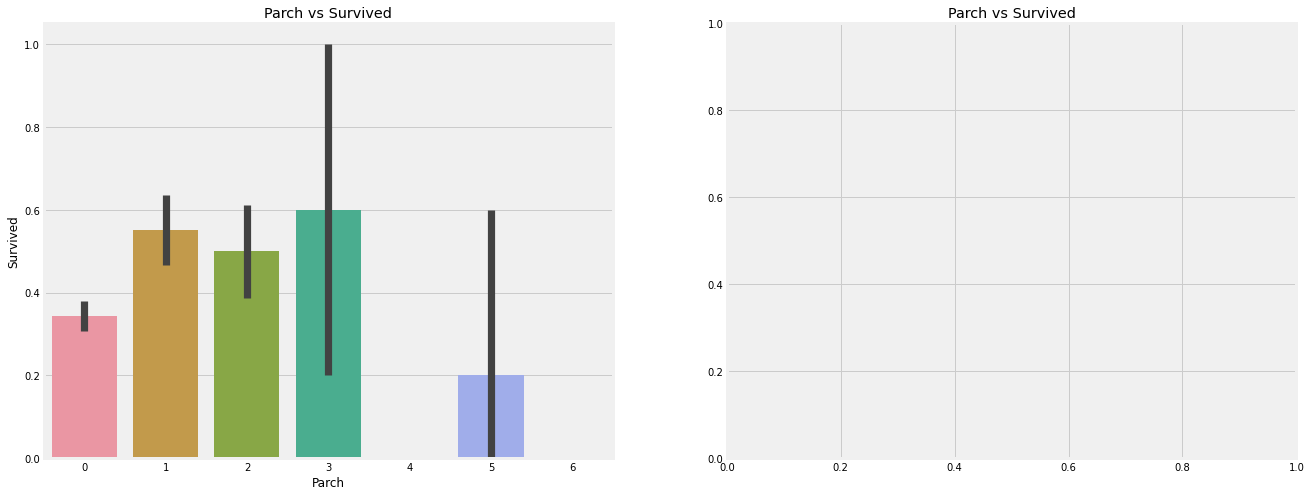

In [554]:
# 绘图可视化出是否有父母和孩子与存活之间的关系
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=data,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

观察:

这里的结果也很相似。带着父母的乘客有更大的生存机会。然而，它随着数字的增加而减少。

在船上的家庭父母人数中有1-3个的人的生存机会是好的。独自一人也证明是致命的，当船上有4个父母时，生存的机会就会减少。

In [555]:
# Fare--> 船票的价格
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


最低票价是0英镑。这价格我也能去！

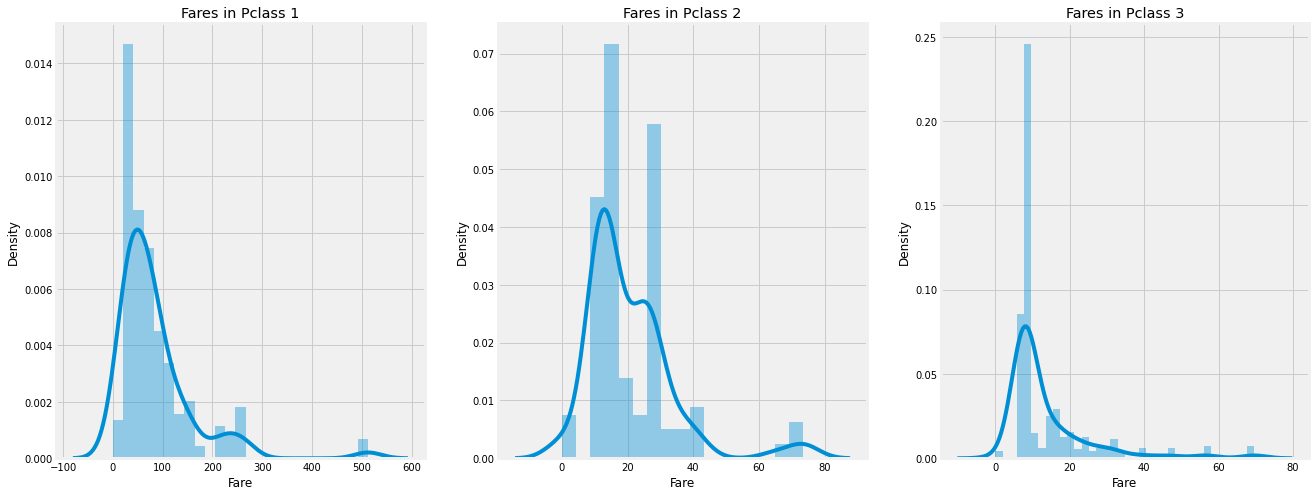

In [556]:
# 绘图可视化
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

概括地观察所有的特征：
性别：与男性相比，女性的生存机会很高。

Pclass：有，第一类乘客给你更好的生存机会的一个明显趋势。对于pclass3成活率很低。对于女性来说，从pclass1生存的机会几乎是。

年龄：小于5-10岁的儿童存活率高。年龄在15到35岁之间的乘客死亡很多。

港口：上来的仓位也有区别，死亡率也很大！

家庭：有1-2的兄弟姐妹、配偶或父母上1-3显示而不是独自一人或有一个大家庭旅行，你有更大的概率存活。

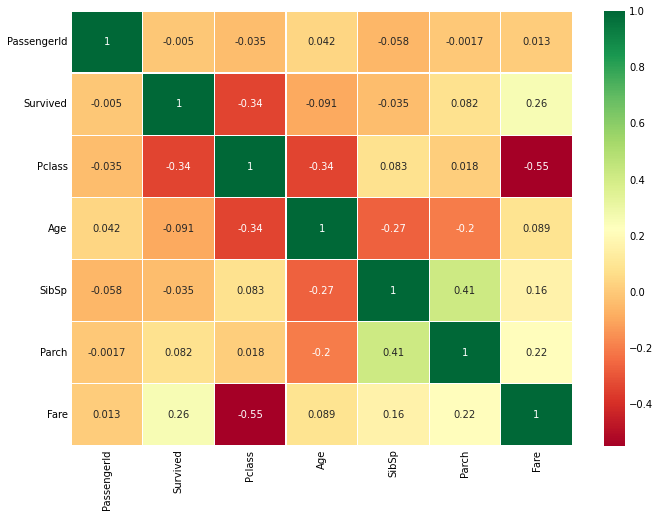

In [557]:
# 特征之间的相关性
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

## 特征相关性的热度图

首先要注意的是，只有数值特征进行比较

正相关：如果特征A的增加导致特征b的增加，那么它们呈正相关。值1表示完全正相关。

负相关：如果特征A的增加导致特征b的减少，则呈负相关。值-1表示完全负相关。

现在让我们说两个特性是高度或完全相关的，所以一个增加导致另一个增加。这意味着两个特征都包含高度相似的信息，并且信息很少或没有变化。这样的特征对我们来说是没有价值的！

那么你认为我们应该同时使用它们吗？。在制作或训练模型时，我们应该尽量减少冗余特性，因为它减少了训练时间和许多优点。

现在，从上面的图，我们可以看到，特征不显著相关。

## 特征工程和数据清洗


当我们得到一个具有特征的数据集时，是不是所有的特性都很重要？可能有许多冗余的特征应该被消除，我们还可以通过观察或从其他特征中提取信息来获得或添加新特性。



### 年龄特征：

正如我前面提到的，年龄是连续的特征，在机器学习模型中存在连续变量的问题。

如果我说通过性别来组织或安排体育运动，我们可以很容易地把他们分成男女分开。

如果我说按他们的年龄分组，你会怎么做？如果有30个人，可能有30个年龄值。

我们需要对连续值进行离散化来分组。

好的，乘客的最大年龄是80岁。所以我们将范围从0-80成5箱。所以80/5＝16。

In [558]:
# 将乘客的年龄分布分为5组，一组的年龄间距为16
# data['Age_band']=0
# data.loc[data['Age']<=16,'Age_band']=0
# data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
# data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
# data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
# data.loc[data['Age']>64,'Age_band']=4
# data.head(2)

In [559]:
# data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')#checking the number of passenegers in each band

In [560]:
# sns.factorplot('Age_band','Survived',data=data,col='Pclass')
# plt.show()


生存率随年龄的增加而减少，不论Pclass。

### Family_size：家庭总人数
光看兄弟姐妹和老人孩子看不太直接，咱们直接看全家的人数

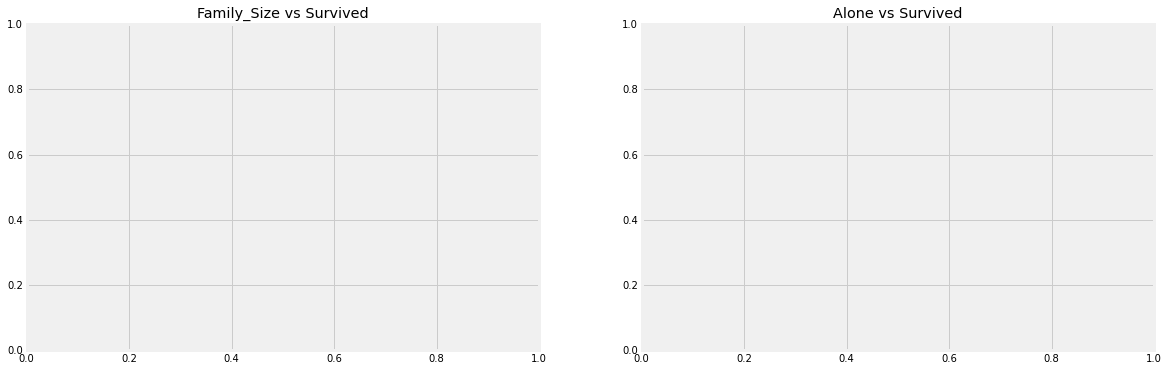

In [561]:
# 新增一个特征列，Family_size---家庭总人数，并通过绘图可视化出来
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

family_size = 0意味着passeneger是孤独的。显然，如果你是单独或family_size = 0，那么生存的机会很低。家庭规模4以上，机会也减少。这看起来也是模型的一个重要特性。让我们进一步研究这个问题。

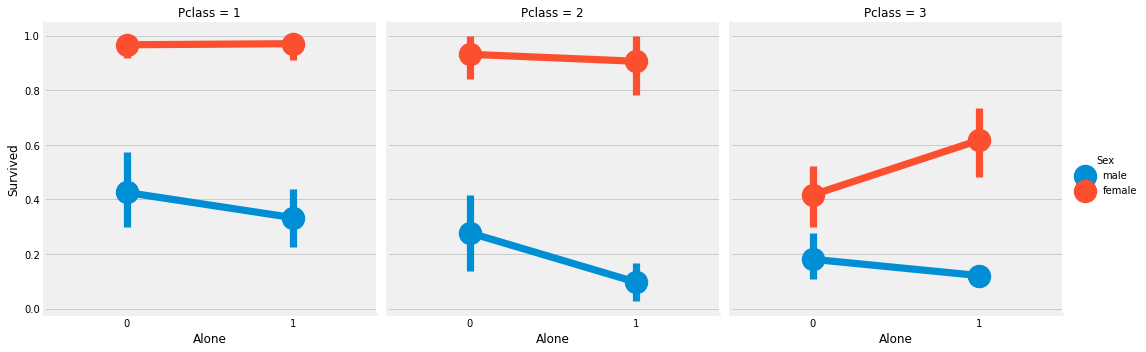

In [562]:
# 绘图可视化
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

### 船票价格
因为票价也是连续的特性，所以我们需要将它转换为数值。

pandas.qcut


In [563]:
# # 将船票价格特征离散化
# data['Fare_Range']=pd.qcut(data['Fare'],4)
# data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

如上所述，我们可以清楚地看到，船票价格增加生存的机会增加。

In [564]:
# data['Fare_cat']=0
# data.loc[data['Fare']<=7.91,'Fare_cat']=0
# data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
# data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
# data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

In [565]:
# # 绘图可视化
# sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
# plt.show()

显然，随着fare_cat增加，存活的几率增加。随着性别的变化，这一特性可能成为建模过程中的一个重要特征。

将字符串值转换为数字
因为我们不能把字符串一个机器学习模型

In [566]:
# 将字符串值转换为数字，类似One-Hot编码
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

去掉不必要的特征

名称--->我们不需要name特性，因为它不能转换成任何分类值

年龄——>我们有age_band特征，所以不需要这个

票号--->这是任意的字符串，不能被归类

票价——>我们有fare_cat特征，所以不需要

船仓号——>这个也不要没啥含义

passengerid --->不能被归类

In [571]:
# 清理掉一些不需要的冗余特征
data.drop(['Name','Ticket','Cabin','PassengerId'],axis=1,inplace=True)
# sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
# fig=plt.gcf()
# fig.set_size_inches(18,15)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()


In [569]:
type(data)

pandas.core.frame.DataFrame

In [572]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial,Family_Size,Alone
0,0,3,0,22.0,1,0,7.2500,0,0,1,0
1,1,1,1,38.0,1,0,71.2833,1,1,1,0
2,1,3,1,26.0,0,0,7.9250,0,2,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,1,0
4,0,3,0,35.0,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0,4,0,1
887,1,1,1,19.0,0,0,30.0000,0,2,0,1
888,0,3,1,22.0,1,2,23.4500,0,2,3,0
889,1,1,0,26.0,0,0,30.0000,1,0,0,1


In [573]:
data.to_csv('tatanic.csv')

现在以上的相关图，我们可以看到一些正相关的特征。他们中的一些人sibsp和family_size和干燥family_size和一些负面的孤独和family_size。

### 机器学习建模
我们从EDA部分获得了一些见解。但是，我们不能准确地预测或判断一个乘客是否会幸存或死亡。现在我们将使用一些很好的分类算法来预测乘客是否能生存下来：

1）logistic回归

2）支持向量机（线性和径向）

3）随机森林

4）k-近邻

5）朴素贝叶斯

6）决策树

7）神经网络

In [102]:
# importing all the required ML packages
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn import svm # support vector Machine
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.naive_bayes import GaussianNB # Naive bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split # training and testing data split
from sklearn import metrics # accuracy measure
from sklearn.metrics import confusion_matrix # for confusion matrix



In [103]:
# 划分训练集与测试集
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

Radial Support Vector Machines(rbf-SVM)

In [104]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


Linear Support Vector Machine(linear-SVM)

In [105]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


Logistic Regression

In [106]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


Decision Tree

In [107]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8097014925373134


K-Nearest Neighbours(KNN)

In [108]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552238806


现在的精度为KNN模型的变化，我们改变n_neighbours值属性。默认值是5。让我们检查的精度在n_neighbours不同时的结果。

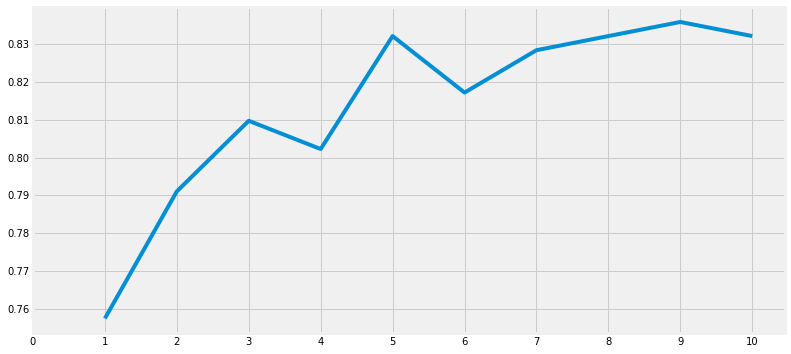

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [109]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

Naive Bayes

In [110]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


Random Forest

In [111]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8171641791044776


模型的精度并不是决定分类器效果的唯一因素。假设分类器在训练数据上进行训练，需要在测试集上进行测试才有效果

现在这个分类器的精确度很高，但是我们可以确认所有的新测试集都是90%吗？答案是否定的，因为我们不能确定分类器在不同数据源上的结果。当训练和测试数据发生变化时，精确度也会改变。它可能会增加或减少。

为了克服这一点，得到一个广义模型，我们使用交叉验证。

### 交叉验证

一个测试集看起来不太够呀，多轮求均值是一个好的策略！

1）的交叉验证的工作原理是首先将数据集分成k-subsets。

2）假设我们将数据集划分为（k＝5）部分。我们预留1个部分进行测试，并对其他4个部分进行训练。

3）我们通过在每次迭代中改变测试部分并在其他部分中训练算法来继续这个过程。然后对衡量结果求平均值，得到算法的平均精度。

这就是所谓的交叉验证。

In [112]:
# 交叉验证
from sklearn.model_selection import KFold # for K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.024061
KNN,0.813783,0.041210
Decision Tree,0.803633,0.031161
Naive Bayes,0.801386,0.028999
Random Forest,0.812597,0.035025


<AxesSubplot:>

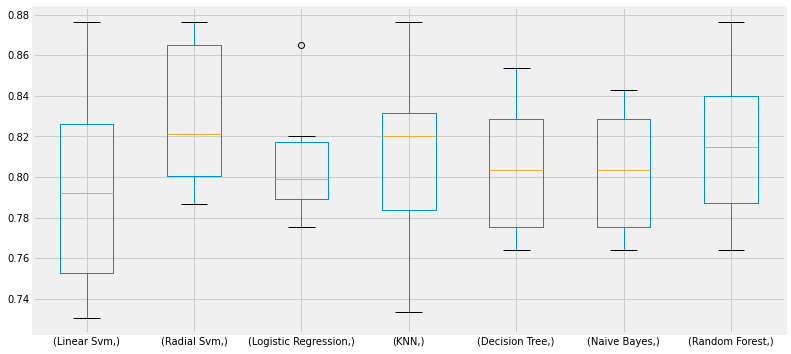

In [113]:
# 画出各种机器学习算法相应的箱型图
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

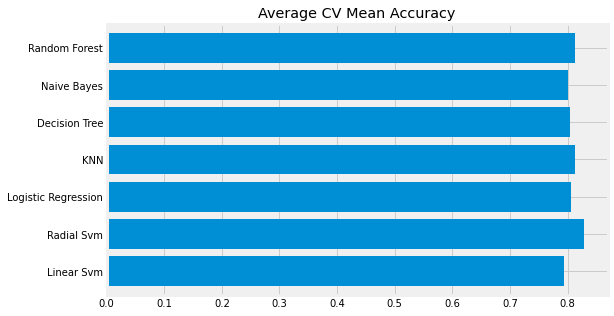

In [114]:
# 画出各种机器学习算法模型的平均精度
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

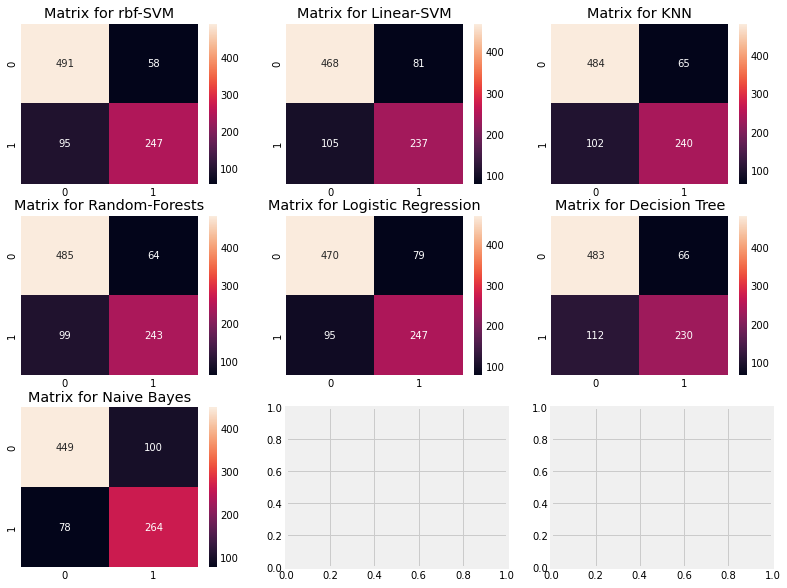

In [115]:
# 绘制混淆矩阵 它给出分类器的正确和不正确分类的数量
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

解释混淆矩阵：来看第一个图

1）预测的正确率为491（死亡）+ 247（存活），平均CV准确率为（491+247）/ 891＝82.8%。

2）58和95都是咱们弄错了的。

### 超参数整定

机器学习模型就像一个黑盒子。这个黑盒有一些默认参数值，我们可以调整或更改以获得更好的模型。比如支持向量机模型中的C和γ，我们称之为超参数，他们对结果可能产生非常大的影响。

In [116]:
# 利用网格搜索来选出最优参数
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8282593685267716
SVC(C=0.4, gamma=0.3)


Random Forests

In [117]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.819327098110602
RandomForestClassifier(n_estimators=300, random_state=0)


RBF支持向量机的最佳得分为82.82%，C＝0.5，γ＝0.1。RandomForest，成绩是81.8% 

### 集成
集成是提高模型的精度和性能的一个很好的方式。简单地说，是各种简单模型的结合创造了一个强大的模型。

1）随机森林类型的，并行的集成

2）提升类型

3）堆叠类型

投票分类器
这是将许多不同的简单机器学习模型的预测结合起来的最简单方法。它给出了一个平均预测结果基于各子模型的预测。

In [118]:
# 投票分类器
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8246268656716418
The cross validated score is 0.8249188514357053


In [119]:
# Bagging方法集成
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8160424469413232


Bagged DecisionTree

In [120]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8208955223880597
The cross validated score for bagged Decision Tree is: 0.8171410736579275



提升是一个逐步增强的弱模型：

首先对完整的数据集进行训练。现在模型会得到一些实例，而有些错误。现在，在下一次迭代中，学习者将更多地关注错误预测的实例或赋予它更多的权重

AdaBoost（自适应增强）
在这种情况下，弱学习或估计是一个决策树。但我们可以改变缺省base_estimator任何算法的选择。

In [121]:
# Adaboost集成
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8249188514357055


In [122]:
# GDBT
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8115230961298376


我们得到了最高的精度为AdaBoost。我们将尝试用超参数调整来增加它。

In [123]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


KeyboardInterrupt: 

我们可以从AdaBoost的最高精度是83.16%，n_estimators = 200和learning_rate = 0.05

Confusion Matrix for the Best Model¶

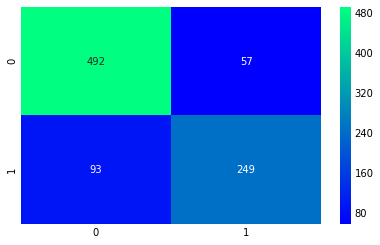

In [ ]:
# 最佳模型的混淆矩阵
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

Feature Importance

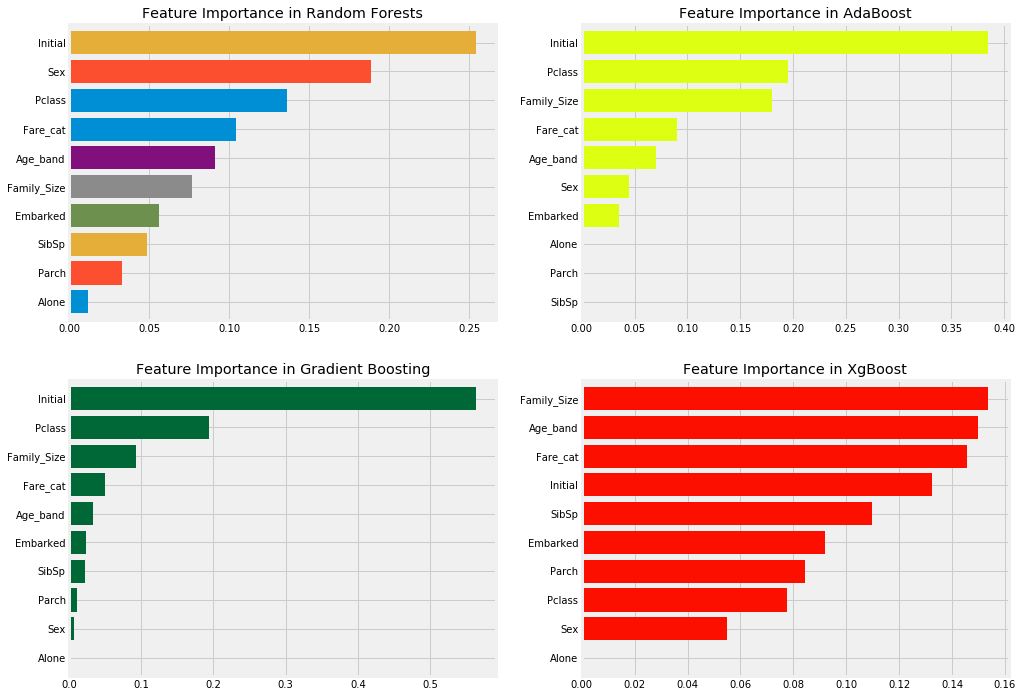

In [ ]:
# Xgboost
import xgboost as xg
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()